<a href="https://colab.research.google.com/github/Azhar304/Image-Processing---Computer-Vision/blob/main/malaria_classification_using_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, InputLayer, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import RootMeanSquaredError



In [62]:
dataset, dataset_info= tfds.load('malaria', with_info=True, as_supervised=True, shuffle_files=True, split=['train'])

In [63]:
# for data in dataset['train'].take(1):
#     print(data)

In [64]:
dataset

[<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]

In [65]:
def split(dataset, train_Ratio, val_ratio, test_ratio):
    dataset_size=len(dataset)
    train_dataset= dataset.take(int(train_Ratio * dataset_size))

    val_test_dataset=dataset.skip(int(train_Ratio*dataset_size))
    val_dataset= val_test_dataset.take(int(val_ratio*dataset_size))

    test_dataset=val_test_dataset.skip(int(val_ratio*dataset_size))

    return train_dataset, val_dataset, test_dataset

In [66]:
#splitting into train test split
train_Ratio=0.8
val_ratio=0.1
test_Ratio=0.1

#dataset= tf.data.Dataset.range(10)
train_dataset, val_dataset , test_dataset= split(dataset[0], train_Ratio, val_ratio, test_Ratio)

print(list(train_dataset.take(1).as_numpy_iterator()), list(val_dataset.take(1).as_numpy_iterator()),
      list(test_dataset.take(1).as_numpy_iterator()))


[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), np.int64(0))] [(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0,

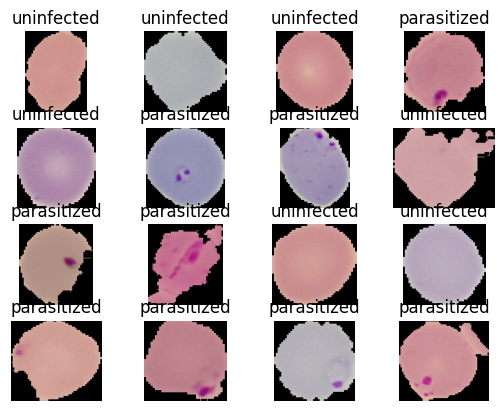

In [67]:
# Data Visualization
for i, (image, label) in enumerate (train_dataset.take(16)):
    ax=plt.subplot(4,4, i+1)
    plt.imshow(image)
    plt.title(dataset_info.features['label'].int2str(label))
    plt.axis('off')

In [68]:
#Data Processing
IM_SIZE=224
def resize_rescale(image, label):
    return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0 , label

In [69]:
train_dataset= train_dataset.map(resize_rescale)
val_dataset= val_dataset.map(resize_rescale)
test_dataset= test_dataset.map(resize_rescale)
train_dataset

<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [70]:
for image, label in train_dataset.take(1):
    print(image, label)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) tf.Tensor(1, shape=(), dtype=int64)


In [71]:
BATCH_SIZE=32
train_dataset=train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset=val_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [72]:
val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [73]:
lenet_model = tf.keras.Sequential([
    InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=2, strides=2, padding='valid'),

    Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=2, strides=2, padding='valid'),

    Flatten(),
    Dense(100, activation='relu'),
    BatchNormalization(),

    Dense(10, activation='relu'),
    BatchNormalization(),
    Dense(1, activation='sigmoid')  # use softmax if you're doing multi-class classification
])

lenet_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 222, 222, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 109, 109, 16)   │           880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 109, 109, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 54, 54, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 46656)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 100)            │     4,665,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,668,297 (17.81 MB)

 Trainable params: 4,668,033 (17.81 MB)

 Non-trainable params: 264 (1.03 KB)

In [74]:
lenet_model.compile(
    optimizer=Adam(learning_rate=0.01),
    loss=BinaryCrossentropy(),
    metrics=['accuracy']
)

In [75]:
history=lenet_model.fit(train_dataset,validation_data=val_dataset, epochs=20, verbose=1)

Epoch 1/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 44s 57ms/step - accuracy: 0.7574 - loss: 0.4801 - val_accuracy: 0.7746 - val_loss: 0.8382
Epoch 2/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 36s 52ms/step - accuracy: 0.9173 - loss: 0.2284 - val_accuracy: 0.9303 - val_loss: 0.2002
Epoch 3/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 36s 52ms/step - accuracy: 0.9359 - loss: 0.1899 - val_accuracy: 0.8661 - val_loss: 0.4591
Epoch 4/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 49s 64ms/step - accuracy: 0.9375 - loss: 0.1836 - val_accuracy: 0.9263 - val_loss: 0.2057
Epoch 5/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 36s 53ms/step - accuracy: 0.9427 - loss: 0.1705 - val_accuracy: 0.9477 - val_loss: 0.2165
Epoch 6/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 36s 52ms/step - accuracy: 0.9511 - loss: 0.1556 - val_accuracy: 0.7710 - val_loss: 0.9467
Epoch 7/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 36s 52ms/step - accuracy: 0.9465 - loss: 0.1576 - val_accuracy: 0.8715 - val_loss: 0.3080
Epoch 8/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 36s 53ms/step - accuracy: 0.9549 - loss: 0.1390 - 

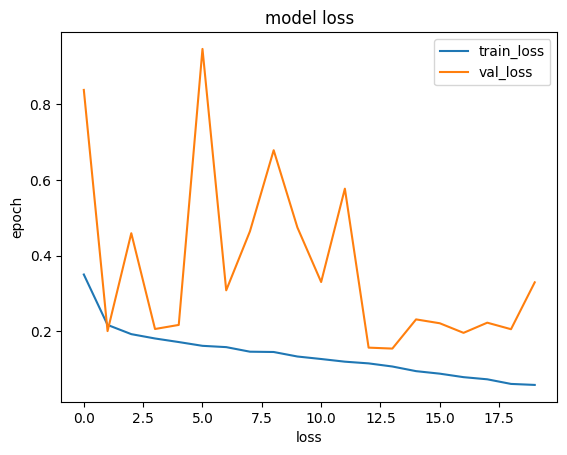

In [76]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('loss')
plt.ylabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()


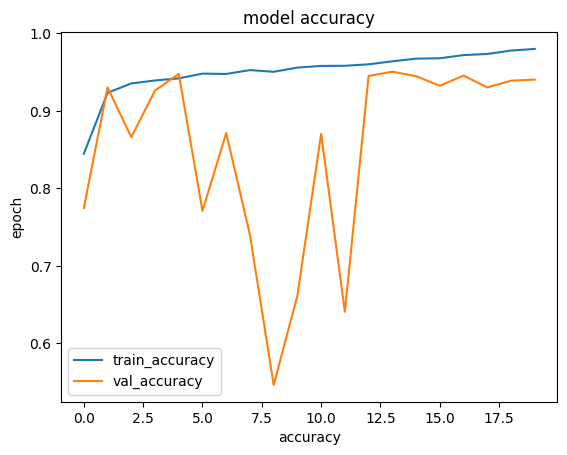

In [77]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.xlabel('accuracy')
plt.ylabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()


In [78]:
test_dataset=test_dataset.batch(1)
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [81]:
lenet_model.evaluate(test_dataset)

2757/2757 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9376 - loss: 0.3700


[0.39090031385421753, 0.9365252256393433]

In [82]:
lenet_model.predict(test_dataset.take(1))[0][0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


np.float32(0.9980233)

In [91]:
def infected_or_not(x):
  if(x<0.5):
    return str('Parasitized')
  else:
    return str('Uninfected')

In [92]:
infected_or_not(lenet_model.predict(test_dataset.take(1))[0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


'Parasitized'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


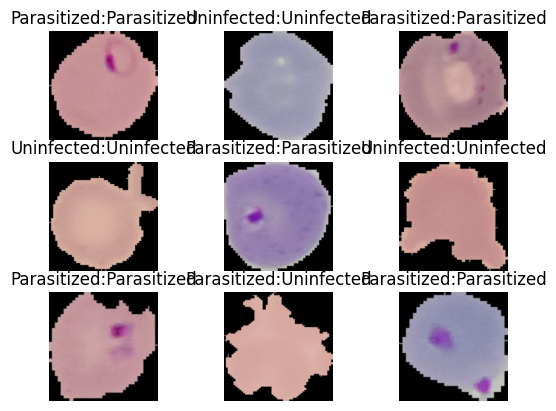

In [95]:
for i, (image,label) in enumerate (test_dataset.take(9)):
  ax=plt.subplot(3,3, i+1)
  plt.imshow(image[0])
  plt.title(str(infected_or_not(label.numpy()[0])) + ":" + str(infected_or_not(lenet_model.predict(image)[0][0])))
  plt.axis('off')